# Сервис аренды самокатов GoFast.

Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо праанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти. В частности, нам нужно выяснить, являются ли платные пользователи более выгодными для компании.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
1) Без подписки:
-  абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;

2) С подпиской Ultra:
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.


# Описание данных

1) Пользователи - users_go.csv
- user_id - уникальный идентификатор пользователя
- name - имя пользователя
- age - возраст
- city - город
- subscription_type - тип подписки (free, ultra)

2) Поездки — rides_go.csv
- user_id - уникальный идентификатор пользователя
- distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date - дата совершения поездки

3) Подписки — subscriptions_go.csv
- subscription_type - тип подписки
- minute_price - стоимость одной минуты поездки по данной подписке
- start_ride_price - стоимость начала поездки
- subscription_fee - стоимость ежемесячного платежа

**Импортируем библиотеки**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from math import sqrt
from math import factorial
from scipy.stats import binom

## Загрузка данных

**Считываем файлы**

In [2]:
df_users = pd.read_csv('/datasets/users_go.csv')
df_rides = pd.read_csv('/datasets/rides_go.csv')
df_subs = pd.read_csv('/datasets/subscriptions_go.csv')

**Выводим и проверяем первые строки каждого набора**

In [3]:
display(df_users.head())
df_users.info()

display(df_rides.head())
df_rides.info()

display(df_subs.head())
df_subs.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Пропусков в данных нет, целочисленные типы можно значительно уменьшить для экономии памяти при помощи pd.to_numeric.

Столбец с датой обработаем в следующем шаге.

In [4]:
pd.to_numeric(df_users['user_id'], downcast='integer')
pd.to_numeric(df_users['age'], downcast='integer')

pd.to_numeric(df_rides['user_id'], downcast='integer')
pd.to_numeric(df_rides['distance'], downcast='float')
pd.to_numeric(df_rides['duration'], downcast='float')

pd.to_numeric(df_subs['minute_price'], downcast='integer')
pd.to_numeric(df_subs['start_ride_price'], downcast='integer')
pd.to_numeric(df_subs['subscription_fee'], downcast='integer')

0      0
1    199
Name: subscription_fee, dtype: int16

## Предобработка данных

### Преобразуем столбец с датой в датафрейме поездок

In [5]:
df_rides['date'] = pd.to_datetime(df_rides['date'], format='%Y-%m-%d')

### Добавим новый столбец с номером месяца

In [6]:
df_rides['month'] = pd.DatetimeIndex(df_rides['date']).month
df_rides['month']

0         1
1         1
2         4
3         8
4         8
         ..
18063    11
18064    11
18065    11
18066    11
18067    12
Name: month, Length: 18068, dtype: int64

### Проверим, за какой период нам предоставили данные.

In [7]:
print('Данные предоставлены за период c', df_rides['date'].min(), 'по', df_rides['date'].max())

Данные предоставлены за период c 2021-01-01 00:00:00 по 2021-12-30 00:00:00


### Проверяем пропуски и дубликаты.

Пропусков нет. Дубликаты присутствуют в малом количестве. Удалим их.

In [8]:
df_users.info()
print()
print(df_users.duplicated().sum())
print()

df_rides.info()
print()
print(df_rides.duplicated().sum())
print()

df_subs.info()
print()
print(df_subs.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB

31

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB

0

<cla

###### Удаляем дубликаты.

In [9]:
df_users.drop_duplicates(inplace=True)
print(df_users.duplicated().sum())

0


## Исследовательский анализ данных

### Анализируем частоту встречаемости городов

,city,user_count
0,Екатеринбург,204
1,Краснодар,193
2,Москва,168
3,Омск,183
4,Пятигорск,219
5,Ростов-на-Дону,198
6,Сочи,189
7,Тюмень,180


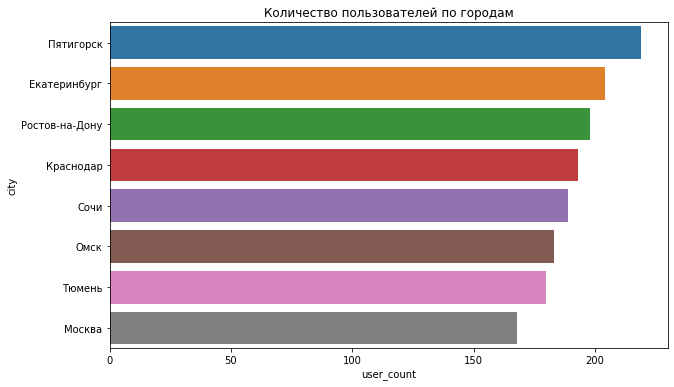

In [10]:
df_users_city = df_users.pivot_table(index='city', values='user_id', aggfunc='count')
df_users_city.reset_index(inplace=True)
df_users_city.rename(columns={'user_id':'user_count'}, inplace=True)
display(df_users_city.head(8))

plt.figure(figsize=(10, 6))
sns.barplot(data=df_users_city.sort_values(by='user_count', ascending=False), x='user_count', y='city')
plt.title('Количество пользователей по городам');

Видим, что больше всего пользователей сервиса живут в Пятигорске, а меньше всего в Москве.

### Анализируем соотношение пользователей с подпиской и без подписки

free     835
ultra    699
Name: subscription_type, dtype: int64

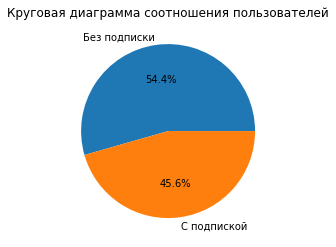

In [11]:
display(df_users['subscription_type'].value_counts())
labels = ['Без подписки', 'С подпиской']
plt.pie(df_users.groupby('subscription_type')['user_id'].count(), labels=labels, autopct='%1.1f%%')
plt.title('Круговая диаграмма соотношения пользователей');

Почти половина пользователей пользуется подпиской, очень хороший результат.

##### Анализируем возраст пользователей

25    145
24    132
26    131
23    129
27    119
22    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
34     19
16     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: age, dtype: int64


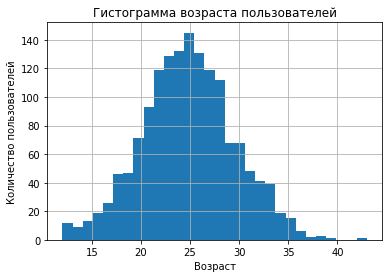

In [12]:
print(df_users['age'].value_counts(ascending=False))


df_users.hist(column='age', bins=30)
plt.title('Гистограмма возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей');

Видим нормальное распределение. Средний возраст пользователя 25 лет. Меньше всего пользователей возрастом менее 15 и старше 35 лет.

### Анализируем расстояние, которое пользователь преодолел за одну поездку

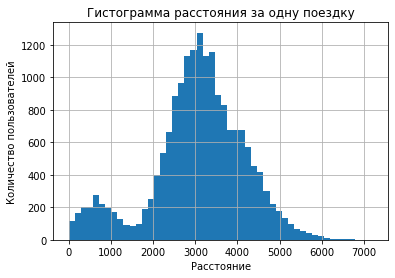

In [13]:
df_rides.hist(column='distance', bins=50)
plt.title('Гистограмма расстояния за одну поездку')
plt.xlabel('Расстояние')
plt.ylabel('Количество пользователей');

Видим, что в среднем пользователи проезжают 3000 метров. При этом выделяется отдельная категория коротких поездок (до 1500 метров) со своим пиком примерно на 600 метрах. Расстояние может быть нулевым, если пользователь сразу же отменил поездку, эти данные оставим.

### Анализируем продолжительность поездок

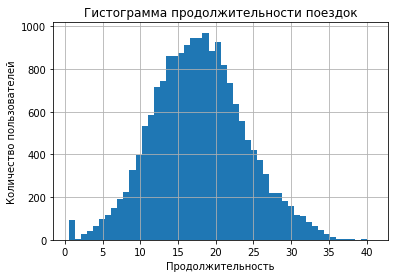

In [14]:
df_rides.hist(column='duration', bins=50)
plt.title('Гистограмма продолжительности поездок')
plt.xlabel('Продолжительность')
plt.ylabel('Количество пользователей');

Средняя продолжительность поездки около 17 минут. Видим небольшой выброс вначале, рассмотрим подробнее.

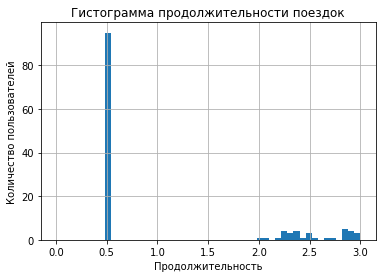

In [15]:
df_rides.hist(column='duration', bins=50, range=(0,3))
plt.title('Гистограмма продолжительности поездок')
plt.xlabel('Продолжительность')
plt.ylabel('Количество пользователей');

Небольшая часть поездок длилась всего пол минуты. Это может быть либо ошибка фиксации времени (минимальное фиксируемое время при ранней отмене поездки), либо доля пользователей, которым попался разряженный самокат.

Посмотрим поближе на эти данные.

In [16]:
display(df_rides[df_rides['duration'] == 0.5])

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


Видим, что расстояние, которое проехали пользователи не соответствует предположению об отмене поездки. Вероятнее всего 0.5 - это пол часа поездки. Причиной такой записи может быть техническая ошибка.

В этих записях заменим 0.5 на 30.

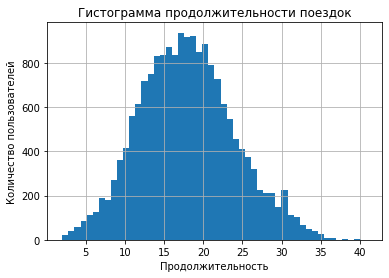

In [17]:
df_rides.loc[df_rides['duration'] == 0.5, 'duration'] = 30
df_rides.hist(column='duration', bins=50)
plt.title('Гистограмма продолжительности поездок')
plt.xlabel('Продолжительность')
plt.ylabel('Количество пользователей');

### Итоги анализа:

- больше всего пользователей сервиса живут в Пятигорске, а меньше всего в Москве;
- почти половина пользователей пользуется подпиской;
- средний возраст пользователя 25 лет;
- средняя продолжительность поездки около 17 минут;
- иногда продолжительность поездок округляется до 0.5 и записывается в формате часов, а не минут.

## Объединение данных

### Объединим данные о пользователях, поездках и подписках в один датафрейм.

Создадим пустой датафрейм df и поместим в него информацию о пользователях и поездках.

In [18]:
df = pd.DataFrame()
df = df_users.merge(df_rides, on='user_id')
display(df.head())

# проверяем
print('df_rides', df_rides.shape)
print('df_users', df_users.shape)
print('df', df.shape)

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


df_rides (18068, 5)
df_users (1534, 5)
df (18068, 9)


Добавляем информацию о подписках.

In [19]:
df = df.merge(df_subs, on='subscription_type')
display(df.head())

# проверяем
print('df_subs', df_subs.shape)
print('df', df.shape)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


df_subs (2, 4)
df (18068, 12)


Проверяем таблицу после объединения.

In [20]:
print(df.info()) # смотрим строки и столбцы
print()
print(df.isnull().sum()) # смотрим пропуски
print()
print('Количество уникальных пользователей:',df['user_id'].nunique()) # смотрим уникальных пользователей

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB
None

user_id              0
name       

### Создаем два датафрейма с данными пользователей с подпиской и без.

In [21]:
df_ultra = df[df['subscription_type'] == 'ultra'] # с подпиской
df_free = df[df['subscription_type'] == 'free'] # бесплатные
df_ultra.info()
print()
df_free.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int64         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB

<class 'pandas.core.frame.DataFrame'>
I

### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

#### Сначала смотрим расстояние.

Платные пользователи:
count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

Бесплатные пользователи:
count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64


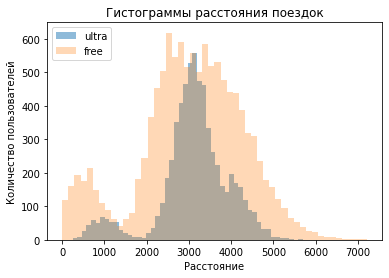

In [22]:
plt.hist(df_ultra['distance'], bins= 50, alpha = 0.5, label='ultra')
plt.hist(df_free['distance'], bins=50, alpha = 0.3, label='free')
plt.legend(loc='upper left')
plt.title('Гистограммы расстояния поездок')
plt.xlabel('Расстояние')
plt.ylabel('Количество пользователей');

print('Платные пользователи:')
print(df_ultra['distance'].describe())
print()
print('Бесплатные пользователи:')
print(df_free['distance'].describe())

Видим, что распределения в целом похожи. У бесплатных пользователей наблюдается два пика - 2500 и 3500 метров. У платных в среднем 3000.

Видим, что подгруппа коротких поездок (до 1500 метров) немного отличается у платных и бесплатных пользователей.
Пользователи без подписки намного чаще совершают короткие поездки.

#### Смотрим на продолжительность поездки

Платные пользователи:
count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

Бесплатные пользователи:
count    11568.000000
mean        17.633172
std          6.239577
min          2.035632
25%         13.127082
50%         17.446822
75%         21.779484
max         34.948498
Name: duration, dtype: float64


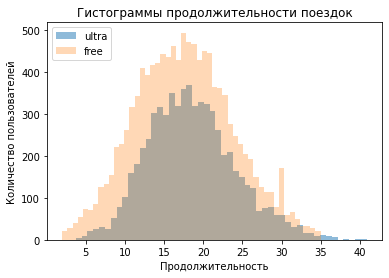

In [23]:
plt.hist(df_ultra['duration'], bins= 50, alpha = 0.5, label='ultra')
plt.hist(df_free['duration'], bins=50, alpha = 0.3, label='free')
plt.legend(loc='upper left')
plt.title('Гистограммы продолжительности поездок')
plt.xlabel('Продолжительность')
plt.ylabel('Количество пользователей');

print('Платные пользователи:')
print(df_ultra['duration'].describe())
print()
print('Бесплатные пользователи:')
print(df_free['duration'].describe())

Видим, что среднее время ~17-18 минут и совпадает у обоих групп пользователей.

## Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.


In [24]:
df['duration'] = np.ceil(df['duration']) # округряем поездки до верхнего целого

df_grouped = df.pivot_table(index=['user_id', 'month'], values=['distance','duration', 'subscription_type', 'start_ride_price', 'subscription_fee', 'minute_price'], \
                            aggfunc={'distance': 'sum', 'duration': ['sum', 'count'], 'subscription_type': 'first', 'start_ride_price': 'first', 'subscription_fee': 'first', 'minute_price': 'first'}) # группируем данные

df_grouped.reset_index(inplace=True)
df_grouped.columns = ['user_id', 'month', 'distance_sum', 'rides_count', 'duration_sum', 'minute_price', 'start_ride_price', 'subscription_fee', 'subscription_type'] # задаем названия столбцов
display(df_grouped.head(10))

,user_id,month,distance_sum,rides_count,duration_sum,minute_price,start_ride_price,subscription_fee,subscription_type
0,1,1,7027.511294,2,42.0,6,0,199,ultra
1,1,4,754.159807,1,7.0,6,0,199,ultra
2,1,8,6723.470560,2,46.0,6,0,199,ultra
3,1,10,5809.911100,2,32.0,6,0,199,ultra
4,1,11,7003.499363,3,56.0,6,0,199,ultra
5,1,12,6751.629942,2,28.0,6,0,199,ultra
6,2,3,10187.723006,3,63.0,6,0,199,ultra
7,2,4,6164.381824,2,40.0,6,0,199,ultra
8,2,6,3255.338202,1,14.0,6,0,199,ultra
9,2,7,6780.722964,2,48.0,6,0,199,ultra


Добавим столбец с помесячной выручкой

In [25]:
df_grouped['month_revenue'] = df_grouped['start_ride_price'] * df_grouped['rides_count'] +  df_grouped['duration_sum'] * df_grouped['minute_price'] + df_grouped['subscription_fee']
display(df_grouped.head())

,user_id,month,distance_sum,rides_count,duration_sum,minute_price,start_ride_price,subscription_fee,subscription_type,month_revenue
0,1,1,7027.511294,2,42.0,6,0,199,ultra,451.0
1,1,4,754.159807,1,7.0,6,0,199,ultra,241.0
2,1,8,6723.470560,2,46.0,6,0,199,ultra,475.0
3,1,10,5809.911100,2,32.0,6,0,199,ultra,391.0
4,1,11,7003.499363,3,56.0,6,0,199,ultra,535.0


## Проверка гипотез

### Часть 1:

H0: пользователи с подпиской тратят столько же времени на поездки, сколько и бесплатные пользователи.

H1: пользователи с подпиской трятят больше времени на поездки, чем бесплатные пользователи.

Используем при проверке тест st.ttest_ind для сравнениния двух генеральных совокупностей. Если pvalue меньше уровня статистической значимости alpha, то отвергаем нулевую гипотезу в пользу альтернативной.

In [26]:
alpha = 0.05

results = st.ttest_ind(df_ultra['duration'], df_free['duration'], alternative='greater')

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: пользователи с подпиской тратят больше времени на поездки, чем бесплатные.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу: пользователи с подпиской тратят столько же времени, сколько и бесплатные.')

p-value: 9.65242247012189e-23
Отвергаем нулевую гипотезу: пользователи с подпиской тратят больше времени на поездки, чем бесплатные.


### Часть 2:

H0: пользователи с подпиской за одну поездку проезжают 3130 метров.

H1: пользователи с подпиской за одну поездку проезжают менее 3130 метров.

Используем при проверке тест st.ttest_1samp для сравнениния двух генеральных совокупностей. Если pvalue меньше уровня статистической значимости alpha, то отвергаем нулевую гипотезу в пользу альтернативной.

In [27]:
alpha = 0.05
opt_dist = 3130

results = st.ttest_1samp(df_ultra['distance'], opt_dist, alternative='less')

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: пользователи с подпиской за одну поездку проезжают менее 3130 метров.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу: пользователи с подпиской за одну поездку проезжают не меньше 3130 метров.')

p-value: 0.08046311521502146
Нет оснований отвергнуть нулевую гипотезу: пользователи с подпиской за одну поездку проезжают не меньше 3130 метров.


### Часть 3:

H0: пользователи с подпиской приносят столько же помесячной выручки, сколько и пользователи без подписки.

H1: пользователи с подпиской приносят больше помесячной выручки, чем пользователи без подписки.

Используем при проверке тест st.ttest_ind для сравнениния двух генеральных совокупностей. Если pvalue меньше уровня статистической значимости alpha, то отвергаем нулевую гипотезу в пользу альтернативной.

In [28]:
alpha = 0.05

results = st.ttest_ind(df_grouped.loc[df_grouped['subscription_type'] == 'ultra', 'month_revenue'], \
                       df_grouped.loc[df_grouped['subscription_type'] == 'free', 'month_revenue'], alternative='greater')

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: пользователи с подпиской приносят больше помесячной выручки, чем пользователи без подписки.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу: пользователи с подпиской приносят столько же помесячной выручки, сколько и пользователи без подписки.')

p-value: 7.430720991422216e-26
Отвергаем нулевую гипотезу: пользователи с подпиской приносят больше помесячной выручки, чем пользователи без подписки.


### Часть 4: 

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Здесь мы используем гипотезу о равенстве средних для зависимых выборок. Применим метод scipy.stats.ttest_rel( ) в который передадим данные перед и после обновления. Параметр alternative = 'less'.

H0: количество обращений после обновления равно количеству обращений до обновления.

H1: количество обращений после обновления меньше количества обращений до обновления.

<p>
<div class="alert-danger">
<b>Комментарий ревьюера ❌</b> 


Являются ли в данном случае выборки независимыми?

<p>
<div class="alert-success">
<b>Комментарий ревьюера 2 ✔️</b>

    
👍</div>

## Распределения

### Часть 1:

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%.

Зададим биномиальное распределение с заданными параметрами методом binom в цикле и подберем такое минимальное количество промокодов n, при котором вероятность получить менее  положительных исходов будет 5%.

In [29]:
for n in range(800, 1800):
    if binom.cdf(99, n, 0.1) <= 0.05:
        print('Необходимое количество промокодов для 95% выполнения плана =', n)
        break

Необходимое количество промокодов для 95% выполнения плана = 1161


### Часть 2:

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

0.15371708296369768


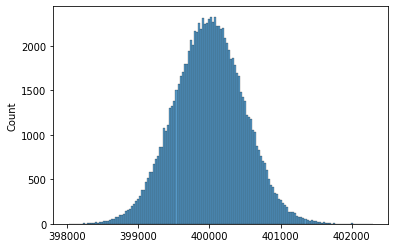

In [30]:
n = 1000000 # количество уведомлений
p = 0.4 # вероятность успеха

mu = n * p
sigma = sqrt(n * p * (1 - p))

distr = st.norm(mu, sigma)

sns.histplot(distr.rvs(100000))

print(distr.cdf(399500))


## Общий вывод.

Мы проанализировали работу сервиса аренды самокатов GoFast за период c 2021-01-01 по 2021-12-30. Ключевой целью было выяснить, являются ли платные подписчики более выгодными для компании.

На этапе **предобработки** мы выполнили следующие действия: 
- добавили столбец с номером месяца;
- удалили дубликаты;

После **исследовательского анализа данных** мы сделали следующие выводы о пользователях:
- больше всего пользователей сервиса живут в Пятигорске и Екатеринбурге, меньше всего в Москве;
- бесплатных пользователей 54%, платных - 46% - почти половина пользуется подпиской, это очень хороший показатель;
- средний возраст пользователя 25 лет, больше всего пользователей находятся в возрастном диапазоне от 20 до 30 лет;
- и бесплатные и платные пользователи проезжают в среднем 3000 метров. При этом выделяется отдельная категория коротких поездок (до 1500 метров);
- средняя продолжительность поездки около 17-18 минут у обоих групп пользователей;

Для **подсчёта выручки** мы создали датафрейм с агрегированной информацией о поездках каждого пользователя и посчитали помесячную выручку.

На основе проведенных исследований и расчетов, было выдвинуто несколько ключевых гипотез, проверка которых, позволила сделать следующие выводы:
- пользователи с подпиской тратят больше времени на поездки, чем бесплатные пользователи, значит им нравится пользоваться сервисом;
- пользователи с подпиской за одну поездку проезжают не меньше 3130 метров. Это больше оптимального расстояния одной поездки с точки зрения износа самоката. Стоит обратить внимание на их обслуживание.
- пользователи с подпиской приносят больше помесячной выручки, чем пользователи без подписки. Факт говорит сам за себя.

**Результаты работы показывают, что платные пользователи более выгодны для компании.**